In [20]:
import glob
import os
import warnings

import librosa
import librosa.display
import matplotlib.pylab as plt
import numpy as np
from PIL import Image

warnings.filterwarnings('ignore')

from project.config import FMA_RAW, DATA_FOLDER, FEATURES_FOLDER
from project.utils.features import compute_melspectrogram
from project.utils.fma import load_tracks

# Classes Distribution

In [2]:
tracks = load_tracks(DATA_FOLDER)

training = tracks['set', 'split'] == "training"
sm_tracks = tracks.loc[tracks['set', 'subset'] <= 'small']
md_tracks = tracks.loc[tracks['set', 'subset'] <= 'medium']

sm_values, sm_counts = np.unique(sm_tracks.loc[training]['track', 'genre_top'],
                                 return_counts=True)
md_values, md_counts = np.unique(md_tracks.loc[training]['track', 'genre_top'],
                                 return_counts=True)

sorted_idx = np.argsort(md_counts)

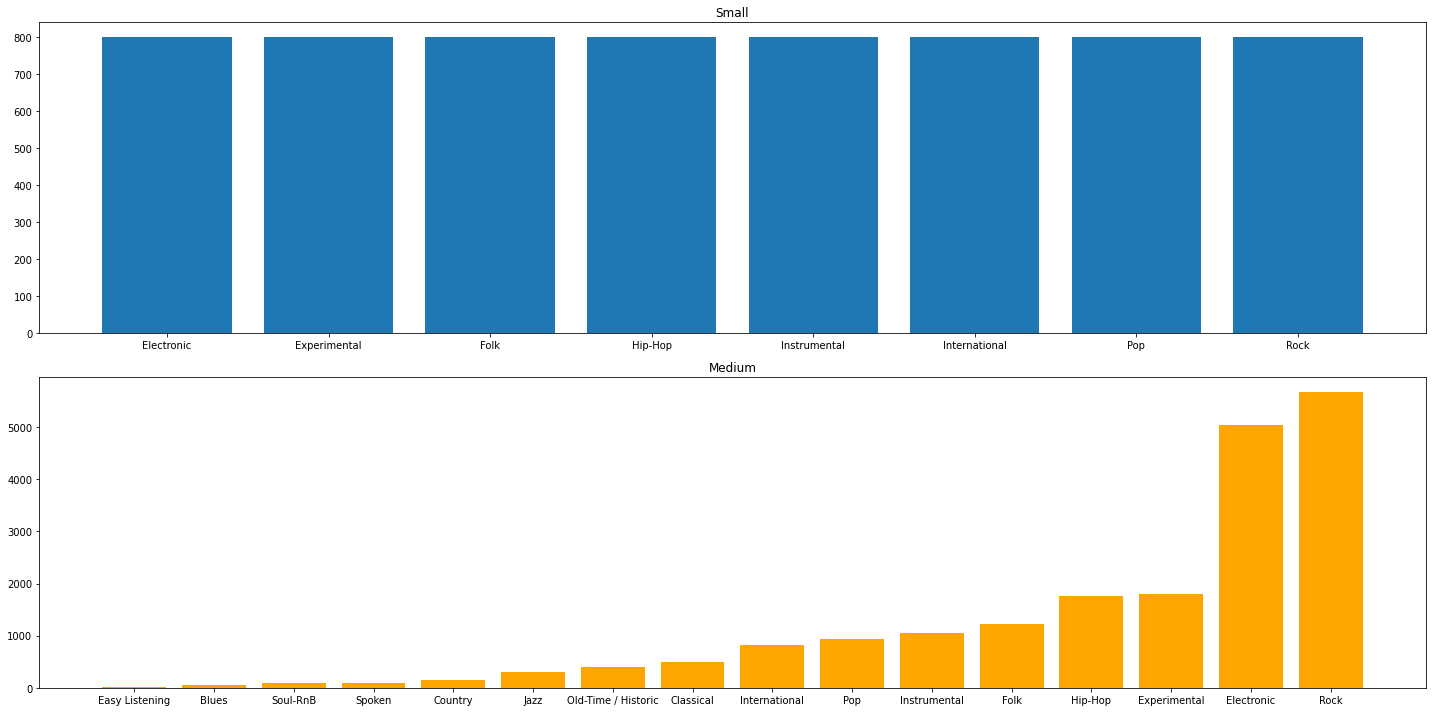

In [3]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(20, 10))
ax1.bar(sm_values, sm_counts)
ax1.set_title("Small")
ax2.bar(md_values[sorted_idx], md_counts[sorted_idx], color='orange')
ax2.set_title("Medium")
fig.tight_layout()

In [4]:
# dataset split percentages
print("[Small]")
print(sm_tracks['set', 'split'].value_counts(normalize=True))

print("\n[Medium]")
print(md_tracks['set', 'split'].value_counts(normalize=True))

[Small]
training      0.8
validation    0.1
test          0.1
Name: (set, split), dtype: float64

[Medium]
training      0.79688
test          0.10292
validation    0.10020
Name: (set, split), dtype: float64


# RAW audio analysis

In [16]:
files = glob.glob(os.path.join(FMA_RAW, "**/*.mp3"), recursive=True)

In [17]:
examples = [
    {"filename": files[0], "genre": "International"},
    {"filename": files[1], "genre": "Hip-Hop"},
    {"filename": files[4], "genre": "Electronic"},
    {"filename": files[5], "genre": "Experimental"},
    {"filename": files[6], "genre": "Folk"},
    {"filename": files[4386], "genre": "Instrumental"},
    {"filename": files[4792], "genre": "Pop"},
    {"filename": files[4744], "genre": "Rock"}
]

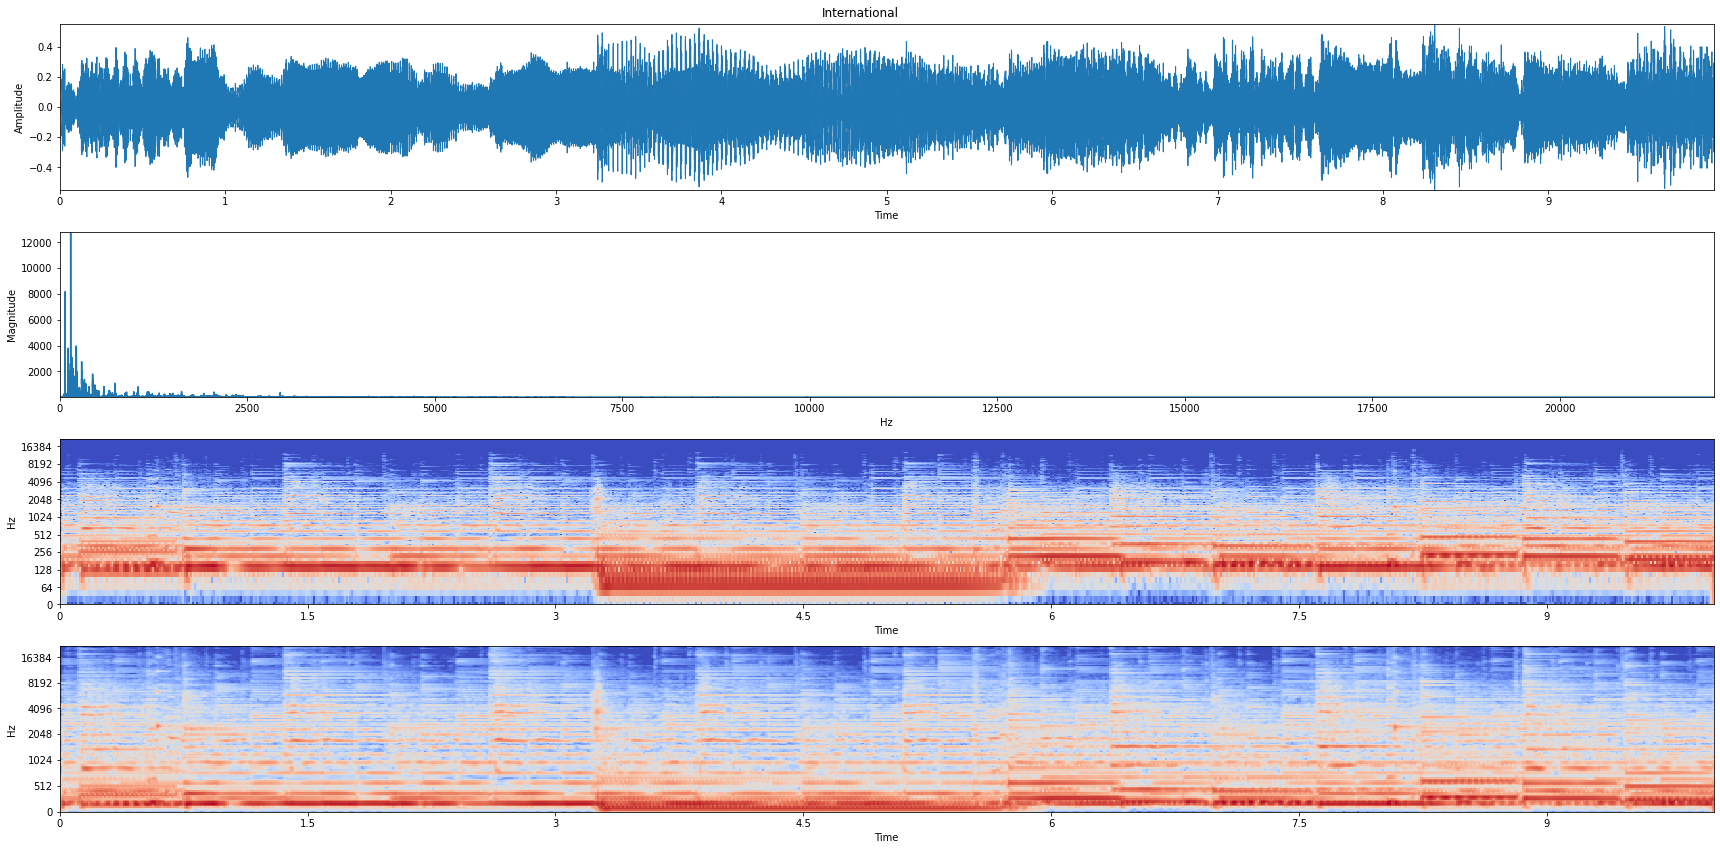

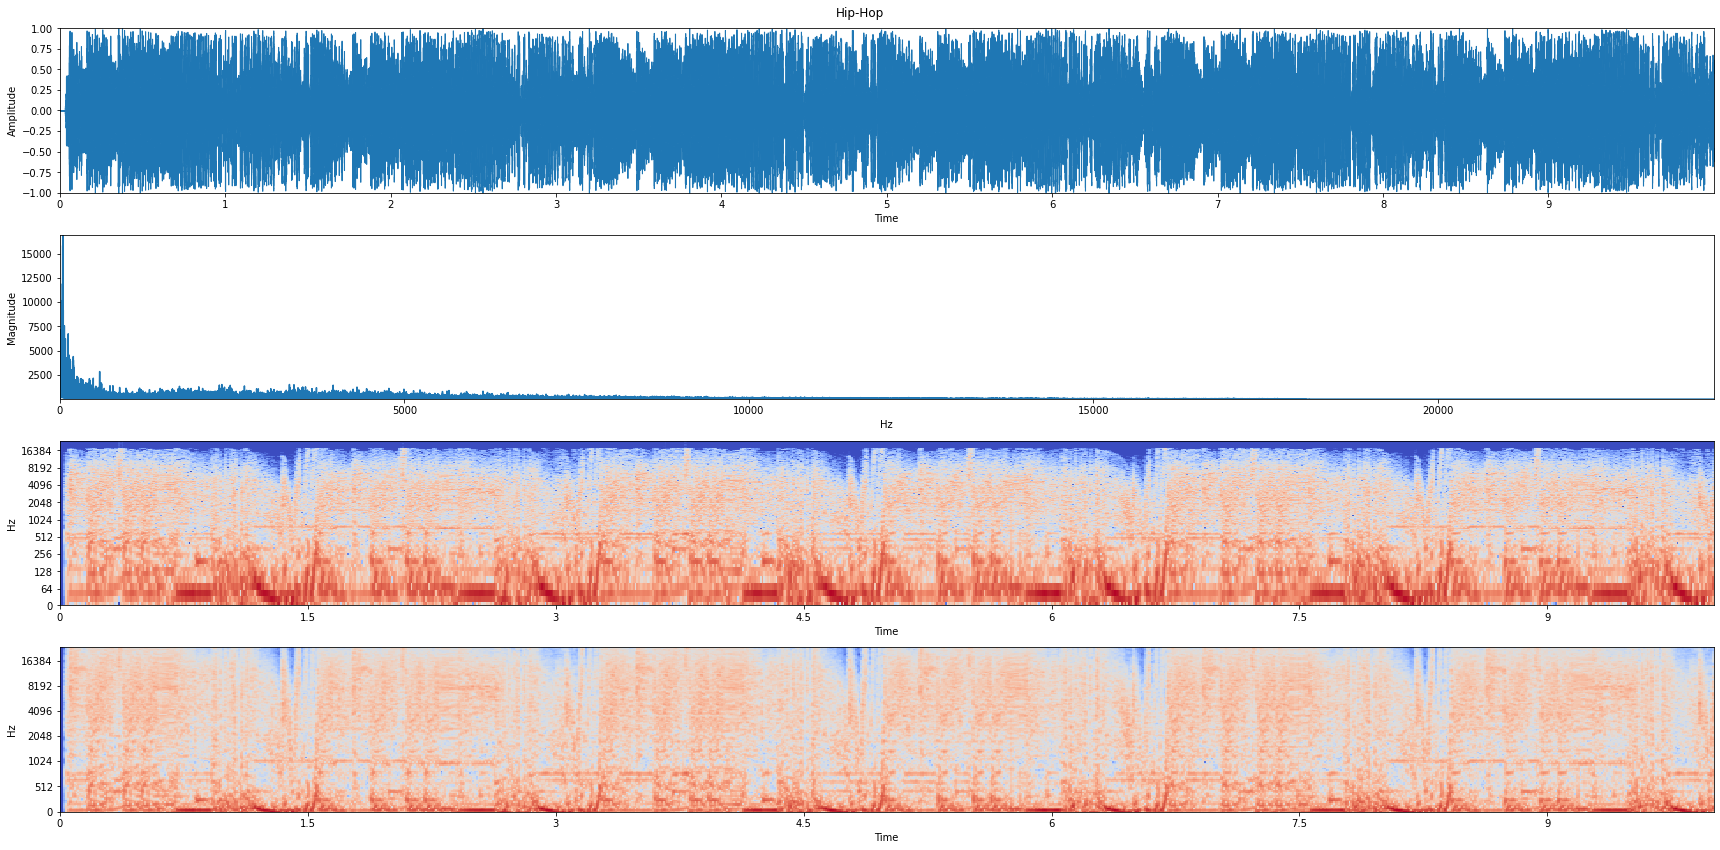

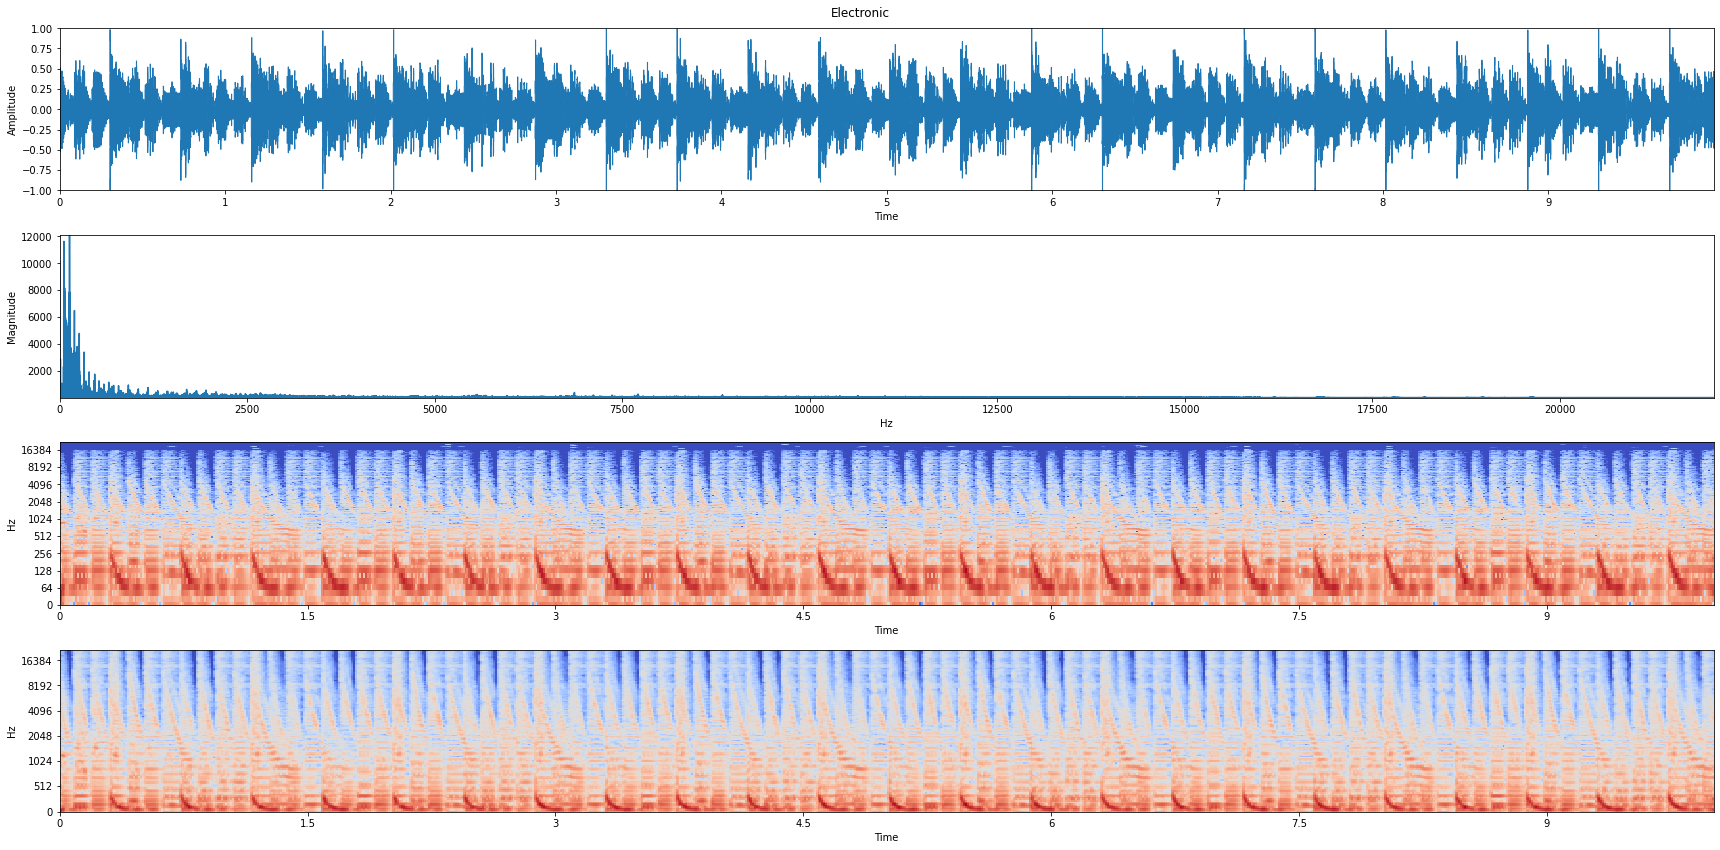

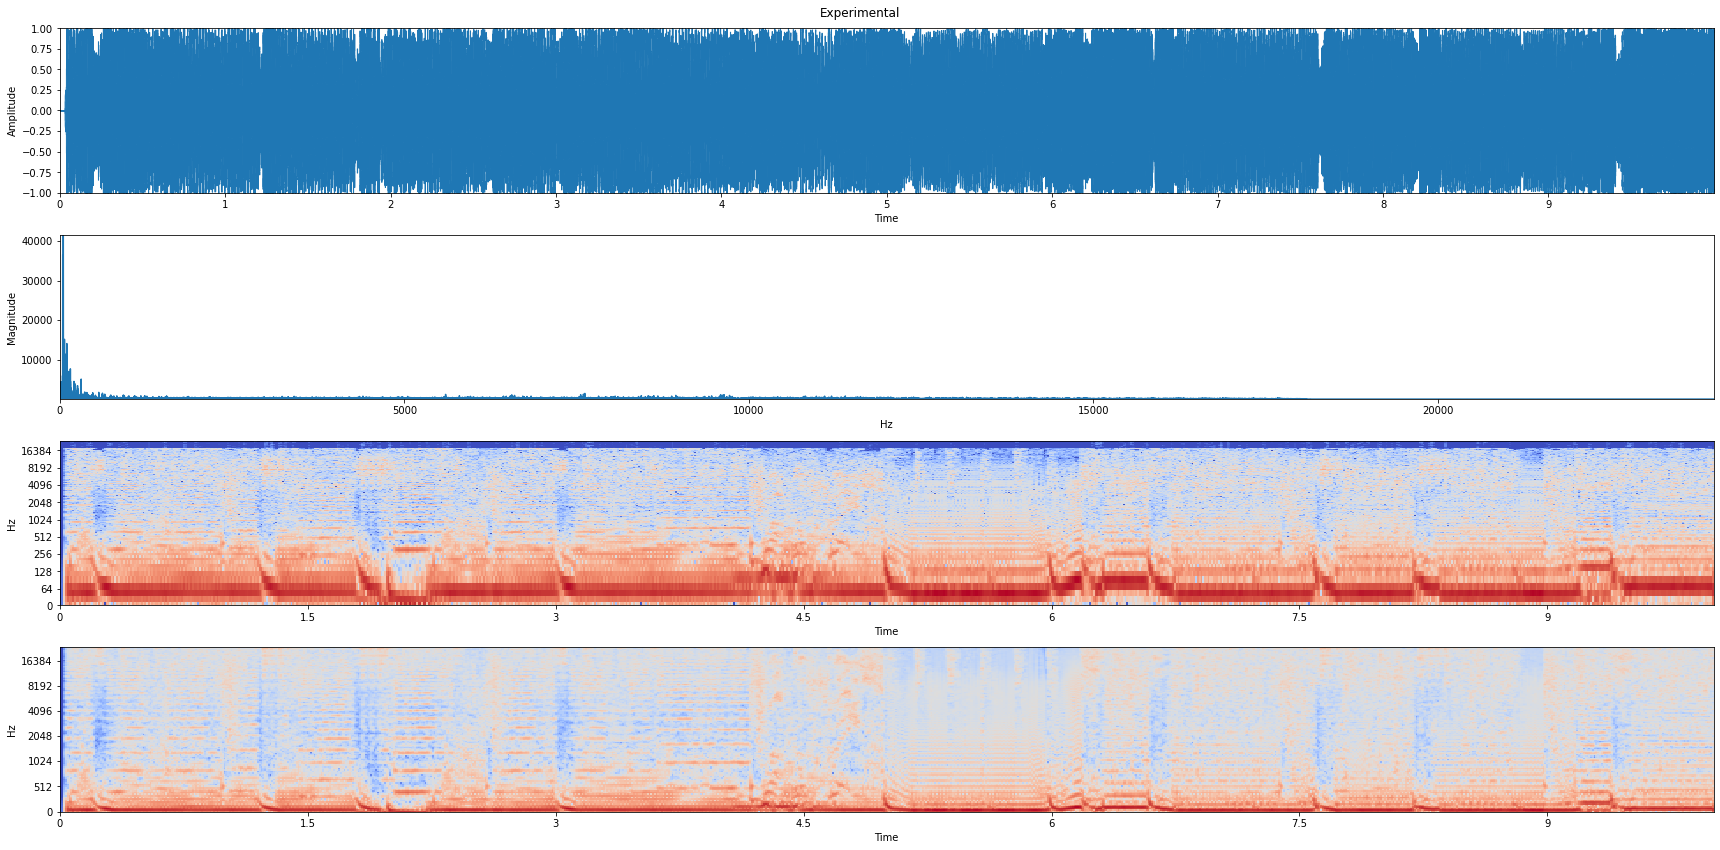

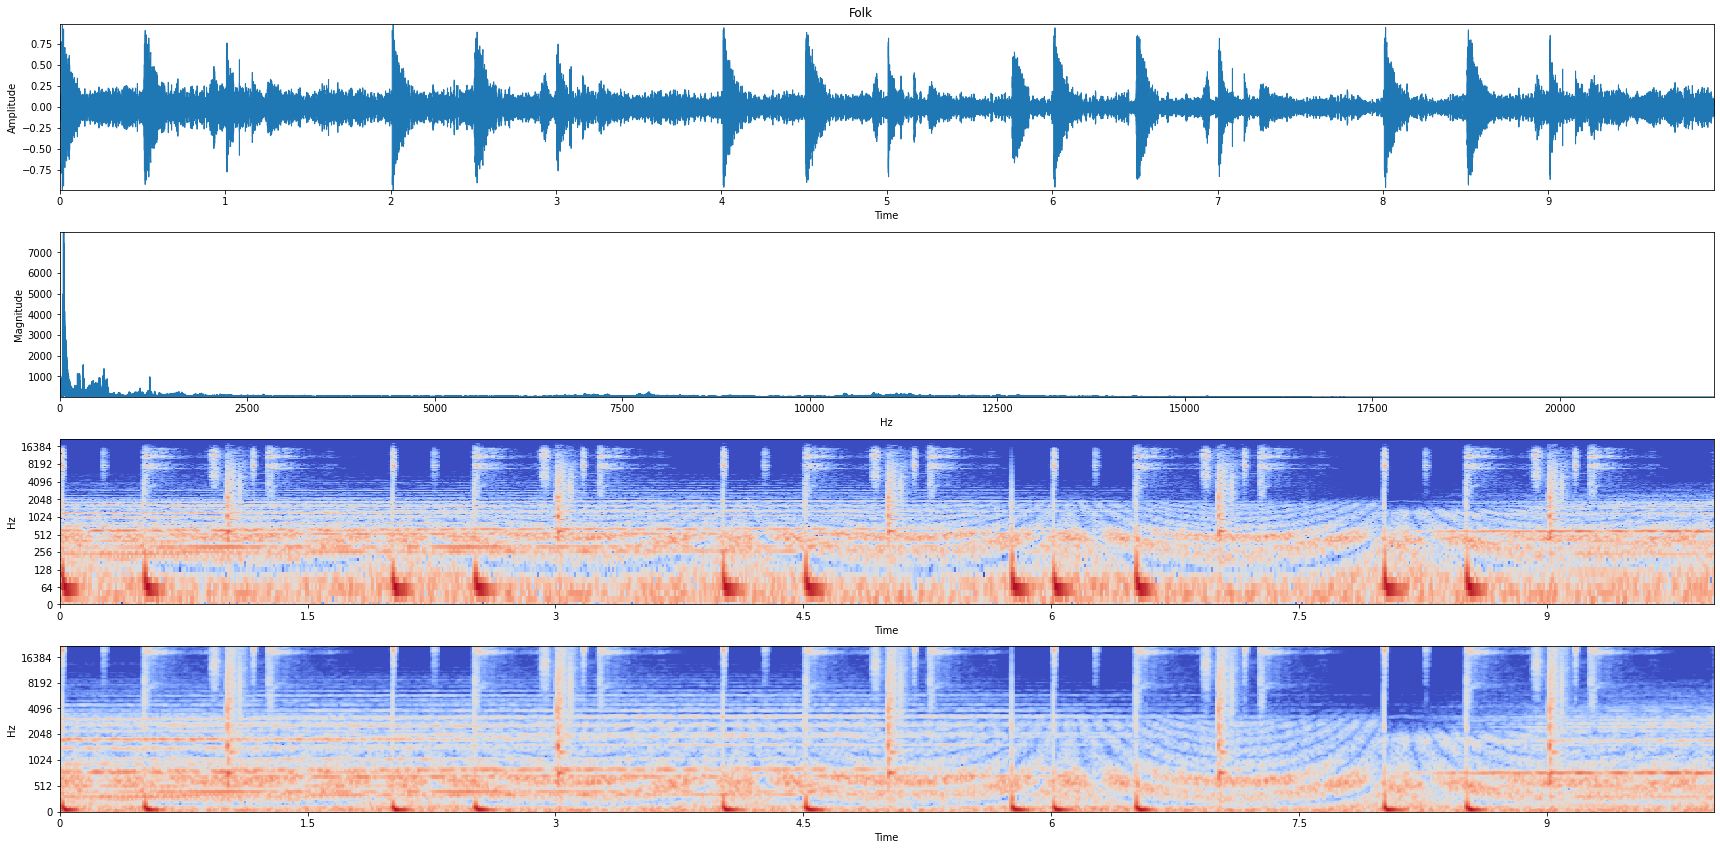

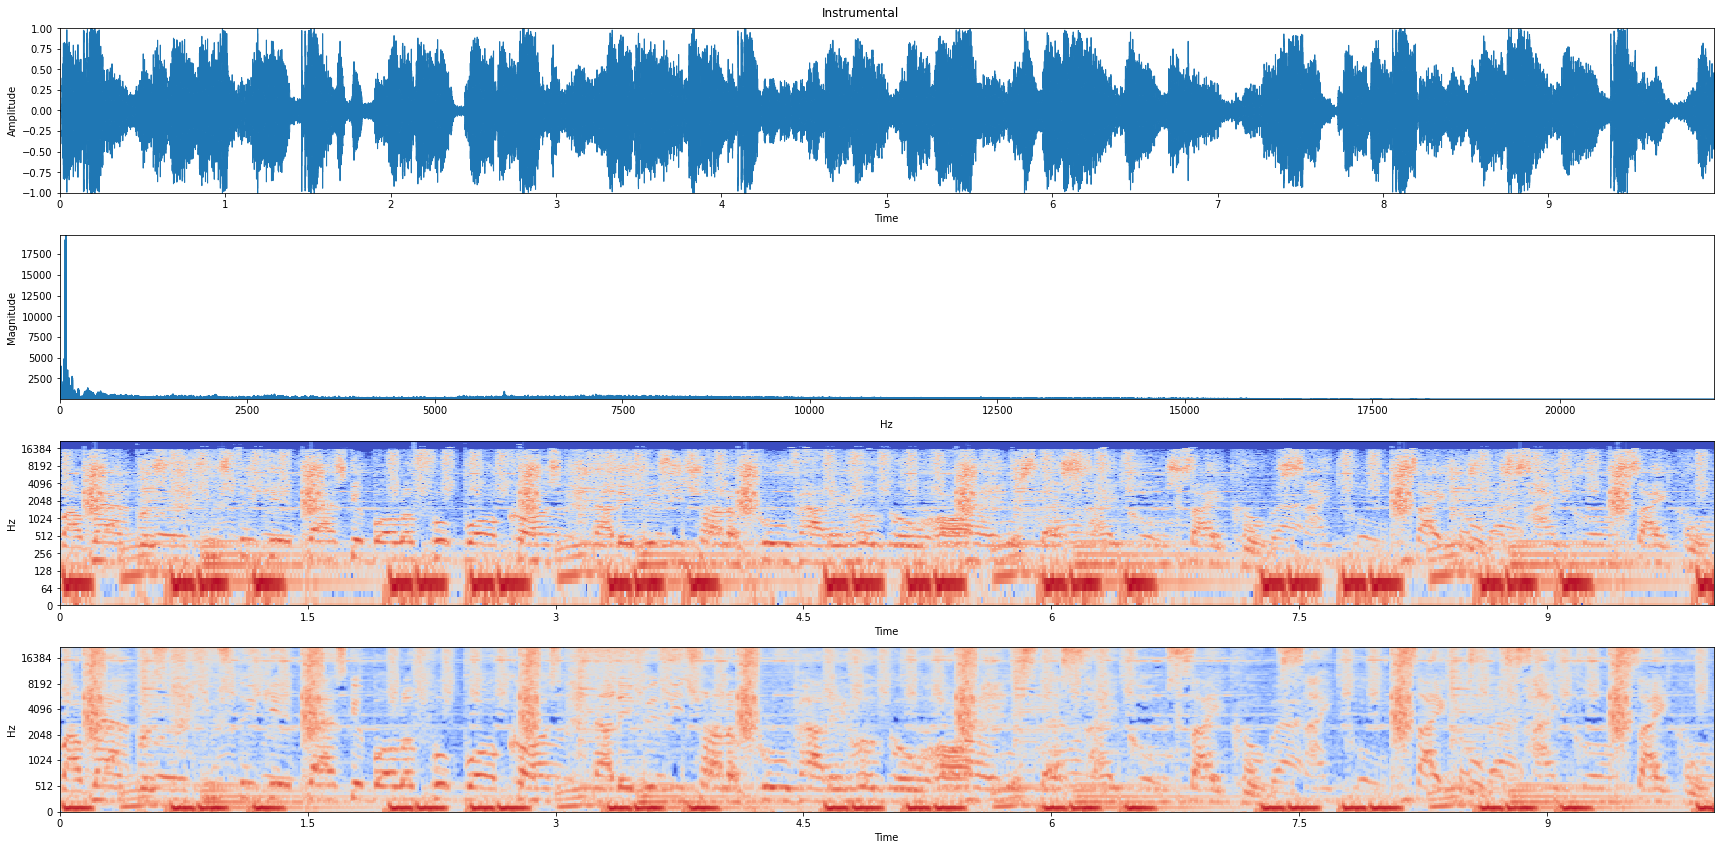

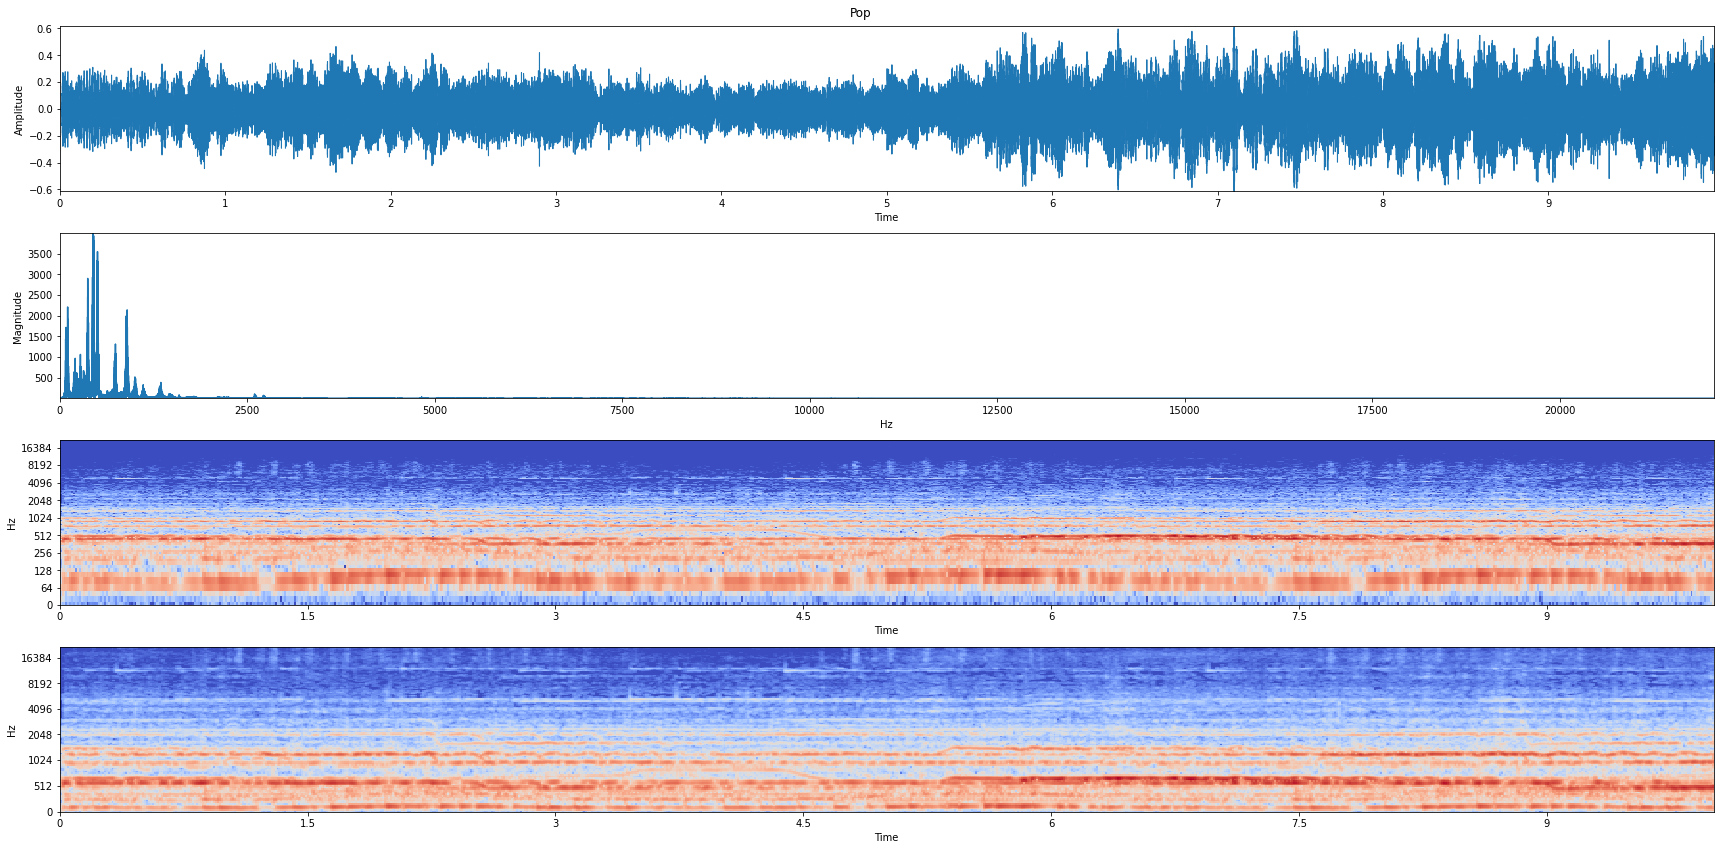

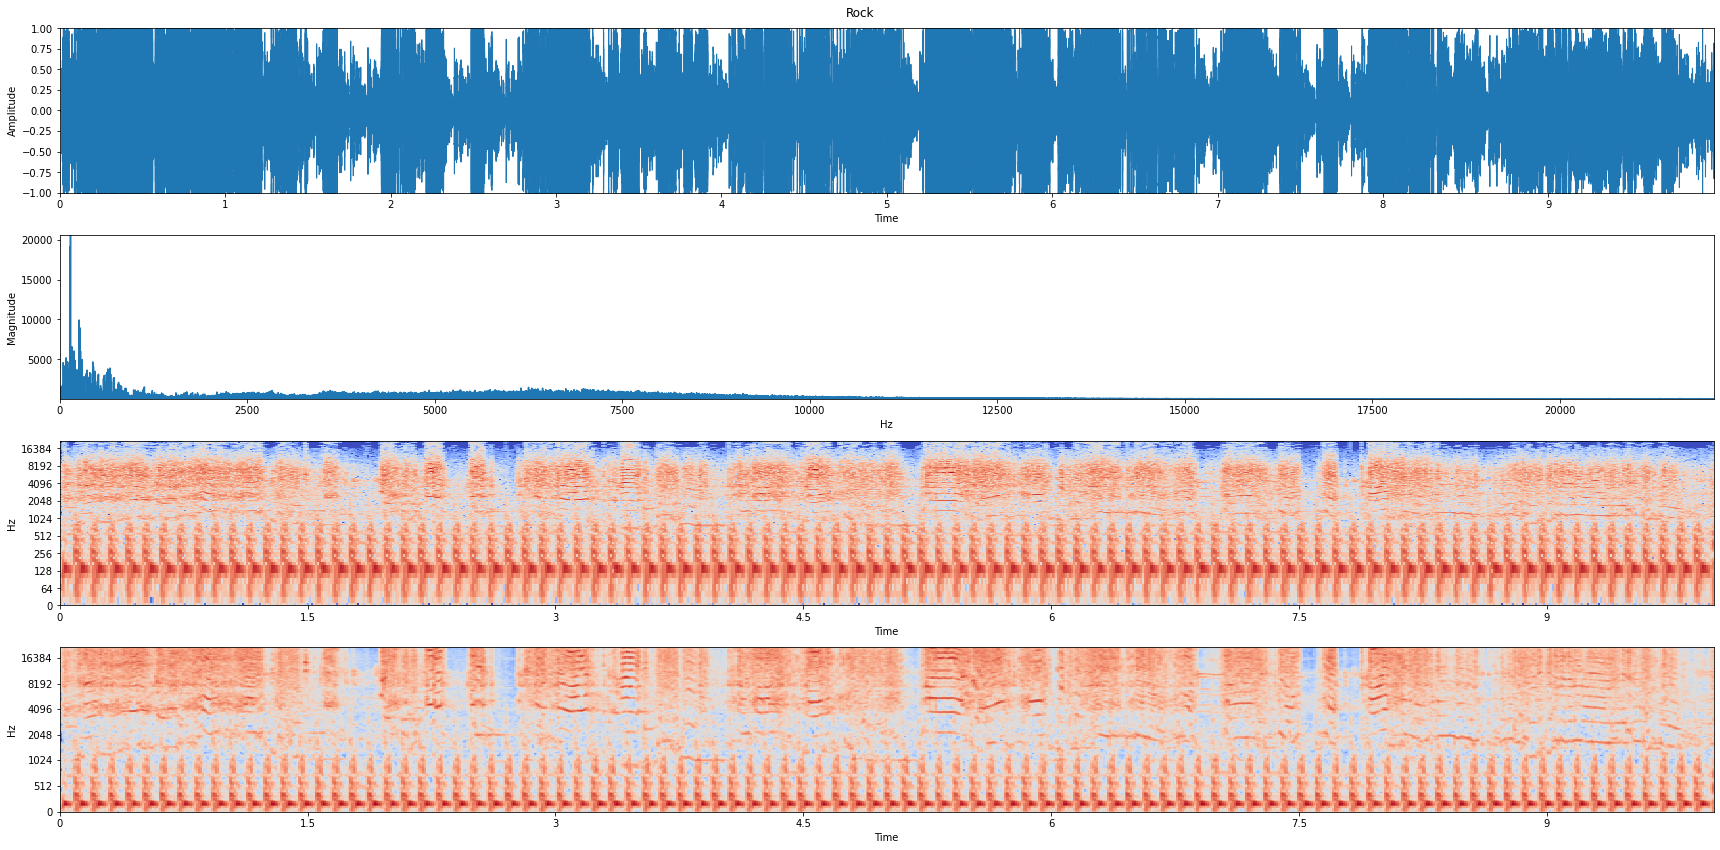

In [19]:
def plot_signal(filepath, seconds=10, title=None):
    y, sr = librosa.load(filepath, sr=None, mono=True)

    y = y[:sr * seconds]

    fft = np.abs(np.fft.fft(y))
    stft = librosa.stft(y, hop_length=512)
    mel_log = compute_melspectrogram(y, sr)
    stft_log = librosa.amplitude_to_db(np.abs(stft))

    fig, axes = plt.subplots(4, 1, figsize=(24, 12))

    librosa.display.waveshow(y, sr=sr, ax=axes[0], x_axis="time")
    axes[1].plot(np.linspace(0, sr, len(fft))[:int(len(fft) / 2)],
                 fft[:int(len(fft) / 2)])
    librosa.display.specshow(stft_log, sr=sr, ax=axes[2], x_axis="time",
                             y_axis="log")
    librosa.display.specshow(mel_log, sr=sr, ax=axes[3], x_axis="time",
                             y_axis="mel")

    axes[0].margins(0)
    axes[1].margins(0)

    axes[0].set_ylabel("Amplitude")
    axes[1].set_ylabel("Magnitude")
    axes[1].set_xlabel("Hz")

    fig.suptitle(title)
    fig.tight_layout()
    fig.show()


for e in examples:
    plot_signal(e["filename"], title=e["genre"])

## Mel Spectrogram for each genre

In [30]:
basedir = os.path.join(FEATURES_FOLDER, 'mel', "training")

examples = {}
for genre in os.listdir(basedir):
    path = os.path.join(basedir, genre, "*.png")
    filenames = glob.glob(path)[:4]

    examples[genre] = filenames

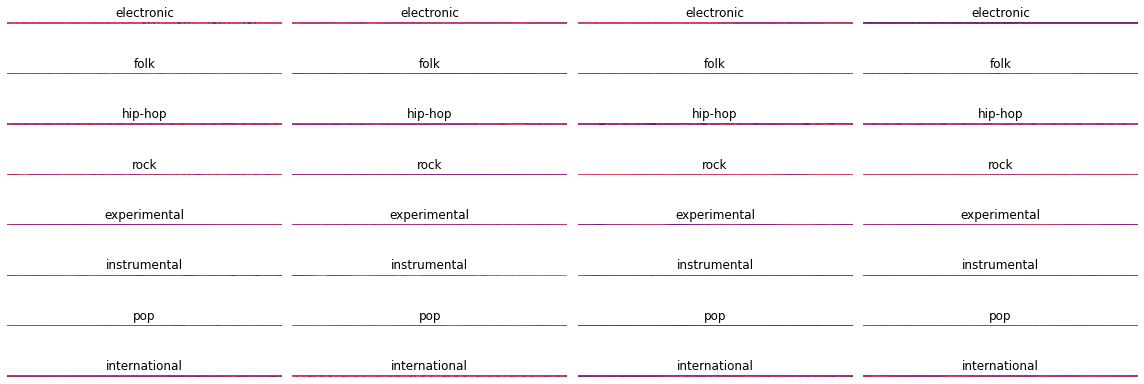

In [31]:
fig, ax = plt.subplots(8, 4, figsize=(16, 8), sharey=True, sharex=True)

for i, (genre, files) in enumerate(examples.items()):
    for j, filename in enumerate(files):
        filepath = os.path.join(basedir, filename)
        mel = np.asarray(Image.open(filepath))

        ax[i, j].imshow(mel, cmap='magma')
        ax[i, j].axis('off')
        ax[i, j].set_title(genre)

fig.tight_layout()

# Check for Bad Samples

In [ ]:
import pandas as pd
from multiprocessing import Pool

from project.config import OUTPUT_FOLDER, SUBSET
from project.utils.bad_samples import get_ignore_list

for f in get_ignore_list(SUBSET):
    f = os.path.join(FMA_RAW, SUBSET, f)
    if f in files:
        files.remove(f)


def get_infos(filepath):
    y, sr = librosa.load(filepath, sr=None, mono=True)
    return sr, librosa.get_duration(y, sr=sr)


# get durations and sample rates

durations = []
sample_rates = []

nb_workers = int(1.5 * len(os.sched_getaffinity(0)))
with Pool(processes=nb_workers) as pool:
    for i, (sr, d) in enumerate(pool.imap(get_infos, files, chunksize=500)):
        durations.append(d)
        sample_rates.append(sr)

        try:
            if i % 500 == 0:
                print(i, (sr, d))

        except BaseException as e:
            print(e)

In [ ]:
plt.plot(sample_rates)

sample_rates = np.array(sample_rates)
sample_rates = pd.DataFrame(sample_rates)
indexes = sample_rates.loc[sample_rates[0] != 44100].index

bad_files = list(np.array(files)[indexes])
np.save(os.path.join(OUTPUT_FOLDER, "bad_samples_files"), bad_files)
print(sample_rates.describe())

In [ ]:
plt.plot(durations)
plt.show()

durations = np.array(durations)
durations = pd.DataFrame(durations)

print(durations.describe())

In [ ]:
print(sum(durations[0] <= 30))
print(sum(durations[0] > 30))
print(sum(durations[0] <= 29.95))